In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

from netam import framework, models
from netam.common import nt_mask_tensor_of, BASES

import sys
sys.path.append("/Users/matsen/re/netam-experiments-1")
from shmex.shm_data import pcp_df_of_non_shmoof_nickname

In [2]:
data_nickname = "shmoof"
pcp_df = pcp_df_of_non_shmoof_nickname(data_nickname)
crepe_path = "../train/trained_models/cnn_joi_lrg-shmoof_small-fixed-0"
crepe = framework.load_crepe(crepe_path)

Loading /Users/matsen/data/shmoof_pcp_2023-11-30_MASKED.csv.gz


In [3]:
import pandas as pd
import numpy as np

def count_codon_mutations(pcp_df, seed=42):
    # Initialize the random number generator
    rng = np.random.default_rng(seed)
    
    # Dictionary to store total counts of mutations across all PCPs
    mutation_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    # Loop over each row in the DataFrame
    for index, row in pcp_df.iterrows():
        parent_seq = row['parent']
        child_seq = row['child']
        
        # Select a random frame
        frame = rng.integers(0, 3)
        
        # Process sequences starting from the selected frame
        for i in range(frame, len(parent_seq) - 2, 3):
            parent_codon = parent_seq[i:i+3]
            child_codon = child_seq[i:i+3]
            
            # Ensure we have complete codons
            if len(parent_codon) == 3 and len(child_codon) == 3:
                # Count mutations
                mutations = sum(1 for a, b in zip(parent_codon, child_codon) if a != b)
                mutation_counts[mutations] += 1

    return mutation_counts


# Call the function
mutation_counts = count_codon_mutations(pcp_df)
print(mutation_counts)


{0: 5792681, 1: 155045, 2: 14023, 3: 1998}


In [4]:
batch_size = 10000
mini_df = pcp_df.iloc[0:batch_size]
ratess, csp_logitss = crepe(mini_df["parent"])

# truncate the last dimension of ratess so it's divisible by 3
ratess = ratess[:, :-(ratess.shape[1] % 3)]

assert pcp_df["parent"].apply(len).max() <= ratess.shape[1]

In [5]:
def mmatch_2(rates):
    """Calculate the moment matching rate for a tensor of two lambda values."""
    inv_rates = 1.0 / rates
    return 1.0 / (inv_rates.sum() - 1.0 / rates.sum())

def mmatch_3(rates):
    """Calculate the moment matching rate for a tensor of three lambda values."""
    inv_rates = 1.0 / rates
    
    # Create a matrix of pairwise sums of rates
    pairwise_sums = rates.unsqueeze(0) + rates.unsqueeze(1)
    
    # Extract the lower triangle part excluding the diagonal to avoid self-pairing
    # and ensure each pair is considered only once
    lower_tri = pairwise_sums.tril(-1)
    
    # Filter out zeros and invert each pairwise sum individually
    nonzero_pairwise_sums = lower_tri[lower_tri != 0]
    inv_nonzero_pairwise_sums = 1.0 / nonzero_pairwise_sums
    
    # Sum the inverted pairwise sums
    sum_inv_pairwise_sums = inv_nonzero_pairwise_sums.sum()

    # Final moment matching calculation for three rates
    return 1.0 / (inv_rates.sum() - sum_inv_pairwise_sums + 1.0 / rates.sum())

# Test the function
def test_mmatch_3():
    rates = torch.tensor([1, 2, 3], dtype=torch.float32)
    expected_result = 0.821917808219178
    calculated_result = mmatch_3(rates)
    assert torch.isclose(calculated_result, torch.tensor(expected_result), atol=1e-6), "mmatch_3 test failed"

test_mmatch_3()

def compute_unscaled_rates(nt_rates):
    """Compute the unscaled rates tensor for codons."""
    assert nt_rates.numel() % 3 == 0, "The length of nt_rates must be a multiple of 3."
    codon_count = nt_rates.shape[0] // 3
    unscaled_rates = torch.zeros((codon_count, 3))

    # Reshape nt_rates for easier slicing
    nt_rates_reshaped = nt_rates.view(-1, 3)

    # Calculate unscaled rates
    for i in range(codon_count):
        rates = nt_rates_reshaped[i]

        # Rate for 1 mutation is simply the sum of rates
        unscaled_rates[i, 0] = rates.sum()

        # Rate for 2 mutations is the sum of mmatch_2 applied to all pairs
        unscaled_rates[i, 1] = mmatch_2(rates[:2]) + mmatch_2(torch.tensor([rates[0], rates[2]])) + mmatch_2(rates[1:])

        # Rate for 3 mutations is mmatch_3 applied to all three rates
        unscaled_rates[i, 2] = mmatch_3(rates)

    return unscaled_rates

def compute_unscaled_ratess(nt_ratess):
    """Compute the unscaled rates tensors for a batch of sequences of nt rates."""
    batch_unscaled_rates = torch.cat([compute_unscaled_rates(nt_rates).unsqueeze(0) for nt_rates in nt_ratess], dim=0)
    return batch_unscaled_rates


# Example usage
nt_rates = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6], dtype=torch.float32)
unscaled_rates = compute_unscaled_rates(nt_rates)
print(unscaled_rates)

unscaled_ratess = compute_unscaled_ratess(ratess)


tensor([[0.6000, 0.3359, 0.0822],
        [1.5000, 0.9735, 0.2623]])


In [6]:
class MultihitModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Parameters for 1, 2, and 3 mutations
        self.log_multihit_rate = nn.Parameter(torch.randn(3))
    
    def forward(self, unscaled_ratess, branch_lengths):
        """
        Compute the full probability distribution across [0, 1, 2, 3] mutations.

        Parameters:
        ----------
        unscaled_ratess : torch.Tensor
            The base mutation rate. Should have shape [batch_size, sequence_length, 3].
        branch_lengths : torch.Tensor
            The branch lengths. Should have shape [batch_size].

        Returns:
        -------
        torch.Tensor
            The full probability distribution across [0, 1, 2, 3] mutations.
            The shape of the tensor will be [batch_size, sequence_length, 4].
        """
        multihit_rate = torch.exp(self.log_multihit_rate)  # multihit_rate has shape [3]
        
        # Expand branch_lengths to match the dimensions of unscaled_ratess
        # Since unscaled_ratess includes the mutation type dimension, expand branch_lengths accordingly
        branch_lengths = branch_lengths.unsqueeze(1).expand(-1, unscaled_ratess.shape[1]).unsqueeze(-1)  # [batch_size, sequence_length, 1]

        # Braodcasting:
        # unscaled_ratess: [batch_size, sequence_length, 3]
        # multihit_rate: [3] broadcasted to [batch_size, sequence_length, 3]
        # branch_lengths: [batch_size, sequence_length, 1] broadcasted to [batch_size, sequence_length, 3]
        mutation_probs = 1 - torch.exp(-unscaled_ratess * multihit_rate * branch_lengths)

        # Probability of zero mutations is 1 minus the sum of probabilities of 1, 2, and 3 mutations
        prob_zero_mutations = 1 - torch.sum(mutation_probs, dim=2)
        
        # Clip the probabilities to ensure they are within the unit interval [0, 1]
        prob_zero_mutations = torch.clamp(prob_zero_mutations, min=0.0, max=1.0)
        
        # Stack the probabilities together: zero mutations first, then 1, 2, 3
        full_probs = torch.cat([prob_zero_mutations.unsqueeze(-1), mutation_probs], dim=2)
        
        # Return the full probability distribution across [0, 1, 2, 3] mutations
        return full_probs




In [7]:
def labels_of_pcp_df(pcp_df, codon_count):
    labels = torch.zeros((len(pcp_df), codon_count), dtype=torch.int64)

    for index, row in pcp_df.iterrows():
        parent_seq = row['parent']
        child_seq = row['child']

        assert len(parent_seq) == len(child_seq)
        valid_length = (len(parent_seq) // 3) * 3
        
        # Check and warn if the valid codon count exceeds the codon_count parameter
        if valid_length // 3 > codon_count:
            print(f"Warning: Truncating sequences at index {index} to {codon_count} codons, though {valid_length // 3} could be processed.")

        # Chunk into codons and count mutations
        num_mutations = []
        for i in range(0, valid_length, 3):
            parent_codon = parent_seq[i:i+3]
            child_codon = child_seq[i:i+3]
            
            if 'N' in parent_codon or 'N' in child_codon:
                num_mutations.append(-1)
            else:
                # Count differing bases
                mutations = sum(1 for p, c in zip(parent_codon, child_codon) if p != c)
                num_mutations.append(mutations)
        
        # Pad or truncate the mutation counts to match codon_count
        padded_mutations = num_mutations[:codon_count]  # Truncate if necessary
        padded_mutations += [-1] * (codon_count - len(padded_mutations))  # Pad with -1s
        
        # Update the labels tensor for this row
        labels[index] = torch.tensor(padded_mutations, dtype=torch.int)

    return labels

# Example usage
data = {
    'parent': ['ATGCGTACGTAG', 'GTCGATCGATCG'],
    'child':  ['ATGCGTAGGTAN', 'GTCGATCGTTGA']
}
example_df = pd.DataFrame(data)
labels_tensor = labels_of_pcp_df(example_df, 4)
print(labels_tensor)


tensor([[ 0,  0,  1, -1],
        [ 0,  0,  1,  2]])


In [8]:
branch_lengths = torch.tensor(mini_df["branch_length"].values)
codon_count = ratess.shape[1] // 3

model = MultihitModel()
criterion = nn.CrossEntropyLoss(ignore_index=-1)

output_probs = model(unscaled_ratess, branch_lengths)
labels = labels_of_pcp_df(mini_df, codon_count)
loss = criterion(output_probs.view(-1, 4), labels.view(-1))
print("Loss:", loss.item())

Loss: 0.8088827595539733


In [9]:
# Calculate value_colunts for labels, which is a tensor
torch.unique(labels, return_counts=True)

(tensor([-1,  0,  1,  2,  3]),
 tensor([725565, 904903,  26755,   2441,    336]))

In [13]:
# randomoly initialize the model
model = MultihitModel()

print(model.state_dict())

OrderedDict([('log_multihit_rate', tensor([-1.9706,  1.0987, -0.6336]))])


Epoch 1/50: 100%|██████████| 10000/10000 [00:00<00:00, 67971.72batch/s, loss=0.811]


Average loss for epoch 1: 0.8140


Epoch 2/50: 100%|██████████| 10000/10000 [00:00<00:00, 81978.60batch/s, loss=0.812]


Average loss for epoch 2: 0.8140


Epoch 3/50: 100%|██████████| 10000/10000 [00:00<00:00, 82489.21batch/s, loss=0.814]


Average loss for epoch 3: 0.8140


Epoch 4/50: 100%|██████████| 10000/10000 [00:00<00:00, 59444.60batch/s, loss=0.814]


Average loss for epoch 4: 0.8140


Epoch 5/50: 100%|██████████| 10000/10000 [00:00<00:00, 78491.81batch/s, loss=0.813]


Average loss for epoch 5: 0.8140


Epoch 6/50: 100%|██████████| 10000/10000 [00:00<00:00, 67653.01batch/s, loss=0.816]


Average loss for epoch 6: 0.8140


Epoch 7/50: 100%|██████████| 10000/10000 [00:00<00:00, 77569.30batch/s, loss=0.813]


Average loss for epoch 7: 0.8140


Epoch 8/50: 100%|██████████| 10000/10000 [00:00<00:00, 59499.33batch/s, loss=0.813]


Average loss for epoch 8: 0.8140


Epoch 9/50: 100%|██████████| 10000/10000 [00:00<00:00, 79970.56batch/s, loss=0.813]


Average loss for epoch 9: 0.8140


Epoch 10/50: 100%|██████████| 10000/10000 [00:00<00:00, 80728.47batch/s, loss=0.819]


Average loss for epoch 10: 0.8140


Epoch 11/50: 100%|██████████| 10000/10000 [00:00<00:00, 63637.51batch/s, loss=0.814]


Average loss for epoch 11: 0.8140


Epoch 12/50: 100%|██████████| 10000/10000 [00:00<00:00, 78102.29batch/s, loss=0.816]


Average loss for epoch 12: 0.8140


Epoch 13/50: 100%|██████████| 10000/10000 [00:00<00:00, 57636.15batch/s, loss=0.812]


Average loss for epoch 13: 0.8140


Epoch 14/50: 100%|██████████| 10000/10000 [00:00<00:00, 77651.73batch/s, loss=0.817]


Average loss for epoch 14: 0.8140


Epoch 15/50: 100%|██████████| 10000/10000 [00:00<00:00, 79367.53batch/s, loss=0.816]


Average loss for epoch 15: 0.8140


Epoch 16/50: 100%|██████████| 10000/10000 [00:00<00:00, 67633.81batch/s, loss=0.811]


Average loss for epoch 16: 0.8140


Epoch 17/50: 100%|██████████| 10000/10000 [00:00<00:00, 58163.26batch/s, loss=0.813]


Average loss for epoch 17: 0.8140


Epoch 18/50: 100%|██████████| 10000/10000 [00:00<00:00, 77239.75batch/s, loss=0.812]


Average loss for epoch 18: 0.8140


Epoch 19/50: 100%|██████████| 10000/10000 [00:00<00:00, 76487.59batch/s, loss=0.811]


Average loss for epoch 19: 0.8140


Epoch 20/50: 100%|██████████| 10000/10000 [00:00<00:00, 76533.93batch/s, loss=0.811]


Average loss for epoch 20: 0.8140


Epoch 21/50: 100%|██████████| 10000/10000 [00:00<00:00, 54425.40batch/s, loss=0.81]


Average loss for epoch 21: 0.8140


Epoch 22/50: 100%|██████████| 10000/10000 [00:00<00:00, 80319.57batch/s, loss=0.81]


Average loss for epoch 22: 0.8140


Epoch 23/50: 100%|██████████| 10000/10000 [00:00<00:00, 78598.60batch/s, loss=0.819]


Average loss for epoch 23: 0.8140


Epoch 24/50: 100%|██████████| 10000/10000 [00:00<00:00, 77208.19batch/s, loss=0.818]


Average loss for epoch 24: 0.8140


Epoch 25/50: 100%|██████████| 10000/10000 [00:00<00:00, 77284.44batch/s, loss=0.811]


Average loss for epoch 25: 0.8140


Epoch 26/50: 100%|██████████| 10000/10000 [00:00<00:00, 52123.03batch/s, loss=0.814]


Average loss for epoch 26: 0.8140


Epoch 27/50: 100%|██████████| 10000/10000 [00:00<00:00, 78752.67batch/s, loss=0.813]


Average loss for epoch 27: 0.8140


Epoch 28/50: 100%|██████████| 10000/10000 [00:00<00:00, 80833.48batch/s, loss=0.813]


Average loss for epoch 28: 0.8140


Epoch 29/50: 100%|██████████| 10000/10000 [00:00<00:00, 79781.79batch/s, loss=0.812]


Average loss for epoch 29: 0.8140


Epoch 30/50: 100%|██████████| 10000/10000 [00:00<00:00, 59287.39batch/s, loss=0.812]


Average loss for epoch 30: 0.8140


Epoch 31/50: 100%|██████████| 10000/10000 [00:00<00:00, 69936.42batch/s, loss=0.807]


Average loss for epoch 31: 0.8140


Epoch 32/50: 100%|██████████| 10000/10000 [00:00<00:00, 79973.15batch/s, loss=0.814]


Average loss for epoch 32: 0.8140


Epoch 33/50: 100%|██████████| 10000/10000 [00:00<00:00, 78374.18batch/s, loss=0.814]


Average loss for epoch 33: 0.8140


Epoch 34/50: 100%|██████████| 10000/10000 [00:00<00:00, 58484.34batch/s, loss=0.811]


Average loss for epoch 34: 0.8140


Epoch 35/50: 100%|██████████| 10000/10000 [00:00<00:00, 78602.72batch/s, loss=0.809]


Average loss for epoch 35: 0.8140


Epoch 36/50: 100%|██████████| 10000/10000 [00:00<00:00, 66169.57batch/s, loss=0.816]


Average loss for epoch 36: 0.8140


Epoch 37/50: 100%|██████████| 10000/10000 [00:00<00:00, 78409.78batch/s, loss=0.812]


Average loss for epoch 37: 0.8140


Epoch 38/50: 100%|██████████| 10000/10000 [00:00<00:00, 78964.09batch/s, loss=0.815]


Average loss for epoch 38: 0.8140


Epoch 39/50: 100%|██████████| 10000/10000 [00:00<00:00, 56406.06batch/s, loss=0.813]


Average loss for epoch 39: 0.8140


Epoch 40/50: 100%|██████████| 10000/10000 [00:00<00:00, 76748.33batch/s, loss=0.814]


Average loss for epoch 40: 0.8139


Epoch 41/50: 100%|██████████| 10000/10000 [00:00<00:00, 68324.60batch/s, loss=0.817]


Average loss for epoch 41: 0.8139


Epoch 42/50: 100%|██████████| 10000/10000 [00:00<00:00, 76937.26batch/s, loss=0.812]


Average loss for epoch 42: 0.8139


Epoch 43/50: 100%|██████████| 10000/10000 [00:00<00:00, 57552.64batch/s, loss=0.814]


Average loss for epoch 43: 0.8139


Epoch 44/50: 100%|██████████| 10000/10000 [00:00<00:00, 78699.17batch/s, loss=0.812]


Average loss for epoch 44: 0.8139


Epoch 45/50: 100%|██████████| 10000/10000 [00:00<00:00, 73453.35batch/s, loss=0.812]


Average loss for epoch 45: 0.8139


Epoch 46/50: 100%|██████████| 10000/10000 [00:00<00:00, 72740.11batch/s, loss=0.816]


Average loss for epoch 46: 0.8139


Epoch 47/50: 100%|██████████| 10000/10000 [00:00<00:00, 58150.28batch/s, loss=0.809]


Average loss for epoch 47: 0.8139


Epoch 48/50: 100%|██████████| 10000/10000 [00:00<00:00, 77818.57batch/s, loss=0.819]


Average loss for epoch 48: 0.8139


Epoch 49/50: 100%|██████████| 10000/10000 [00:00<00:00, 78860.61batch/s, loss=0.81]


Average loss for epoch 49: 0.8139


Epoch 50/50: 100%|██████████| 10000/10000 [00:00<00:00, 76623.69batch/s, loss=0.813]


Average loss for epoch 50: 0.8139


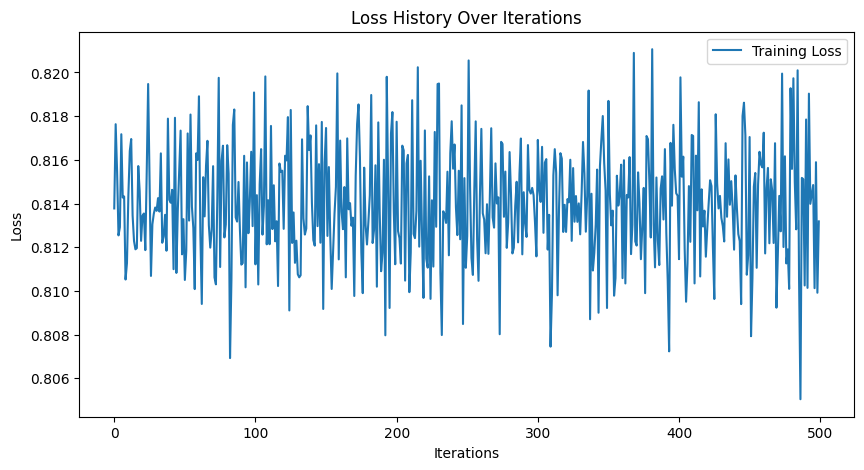

In [18]:

# Assuming your model is already defined and instantiated as 'model'
# Assuming criterion and optimizer are also set up
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(model.parameters(), lr=0.0001)  # adjust learning rate as necessary

# Example settings for epochs and batch processing
epochs = 50
batch_size = 1000  # Define an appropriate batch size for your data

# Setup DataLoader if your dataset is large or needs to be batched
from torch.utils.data import DataLoader, TensorDataset

# Assuming unscaled_ratess, branch_lengths, and labels are torch Tensors
dataset = TensorDataset(unscaled_ratess, branch_lengths, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# List to store loss values to plot later
loss_history = []

# Training loop with batches
for epoch in range(epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0
    with tqdm(total=len(dataloader.dataset), desc=f"Epoch {epoch + 1}/{epochs}", unit='batch') as pbar:
        for unscaled_rates_batch, branch_lengths_batch, labels_batch in dataloader:
            # Compute model output and loss
            output_probs = model(unscaled_rates_batch, branch_lengths_batch)
            loss = criterion(output_probs.view(-1, 4), labels_batch.view(-1))
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record loss and update progress bar
            loss_history.append(loss.item())
            epoch_loss += loss.item() * unscaled_rates_batch.size(0)
            pbar.update(len(unscaled_rates_batch))
            pbar.set_postfix({'loss': loss.item()})

    # Average loss for the epoch
    epoch_loss /= len(dataloader.dataset)
    print(f"Average loss for epoch {epoch + 1}: {epoch_loss:.4f}")

# Plotting the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Loss History Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
print(model.state_dict())

OrderedDict([('log_multihit_rate', tensor([-1.9721,  1.0798, -0.6346]))])


In [21]:
criterion(output_probs.view(-1, 4), labels_batch.view(-1))

tensor(0.8132, dtype=torch.float64, grad_fn=<NllLossBackward0>)

In [23]:
# set all entries of model.log_multihit_rate[:] to 0
model.log_multihit_rate.data[:] = 0


In [24]:

criterion(output_probs.view(-1, 4), labels_batch.view(-1))

tensor(0.8132, dtype=torch.float64, grad_fn=<NllLossBackward0>)

In [27]:
# show entries of labels_batch that are not -1
labels_batch[labels_batch != -1].unique(return_counts=True)

(tensor([0, 1, 2, 3]), tensor([89864,  2626,   261,    38]))